In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
df = pd.read_csv("../data/raw/housing.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


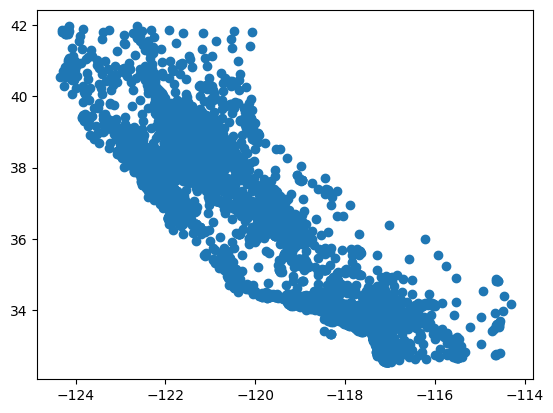

In [4]:
plt.scatter(df.longitude, df.latitude)
plt.show()

In [6]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


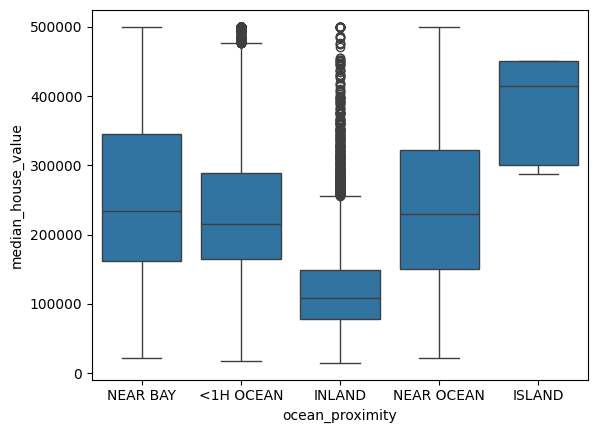

In [7]:
sns.boxplot(x = 'ocean_proximity', y = 'median_house_value', data = df)
plt.show()

In [8]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [11]:
def remove_outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQ = Q3 - Q1
    # LI = Q1 < (Q1 - 1.5 * IQ)
    # LS = Q3 > (Q3 + 1.5 * IQ)

    # df_final = df[~(LI | LS)]
    df_final = df[~((df < (Q1 - 1.5 * IQ)) | (df > (Q3 + 1.5 * IQ)))]
    return df_final


In [12]:
df_removido = remove_outlier(df['housing_median_age'])
df_removido = pd.DataFrame(df_removido)

In [13]:
media_housing_median_age = df.housing_median_age.mean()
print(media_housing_median_age)

28.639486434108527


In [14]:
from sklearn.neighbors import KNeighborsRegressor

# function that imputes a dataframe 
def impute_knn(df):
    
    ''' inputs: pandas df containing feature matrix '''
    ''' outputs: dataframe with NaN imputed '''
    # imputation with KNN unsupervised method

    # separate dataframe into numerical/categorical
    ldf = df.select_dtypes(include=[np.number])           # select numerical columns in df
    ldf_putaside = df.select_dtypes(exclude=[np.number])  # select categorical columns in df
    # define columns w/ and w/o missing data
    cols_nan = ldf.columns[ldf.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ldf.columns.difference(cols_nan).values     # columns w/o nan 

    for col in cols_nan:                
        imp_test = ldf[ldf[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ldf.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ldf.loc[df[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ldf,ldf_putaside],axis=1)

In [15]:
df2 = impute_knn(df)
# looks like we have a full feature matrix
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [16]:
from sklearn.model_selection import train_test_split
trdata,tedata = train_test_split(df2,test_size=0.2,random_state=42)

### Análise de Dados

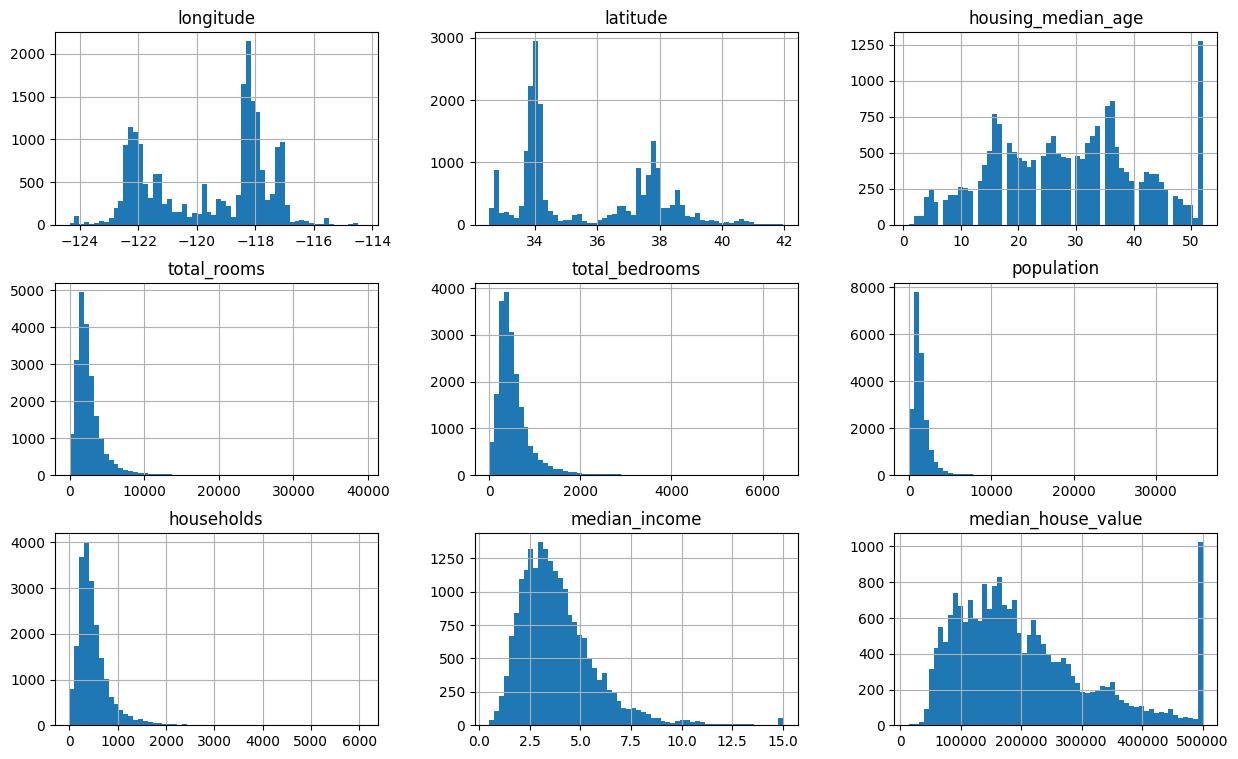

In [17]:
df.hist(bins=60, figsize=(15,9))
plt.show()

In [18]:
def corrMat(df,id=False):
    
    corr_mat = df.corr(numeric_only=True).round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0, 
                cmap='plasma',square=False,lw=2,annot=True,cbar=False)
    plt.show()

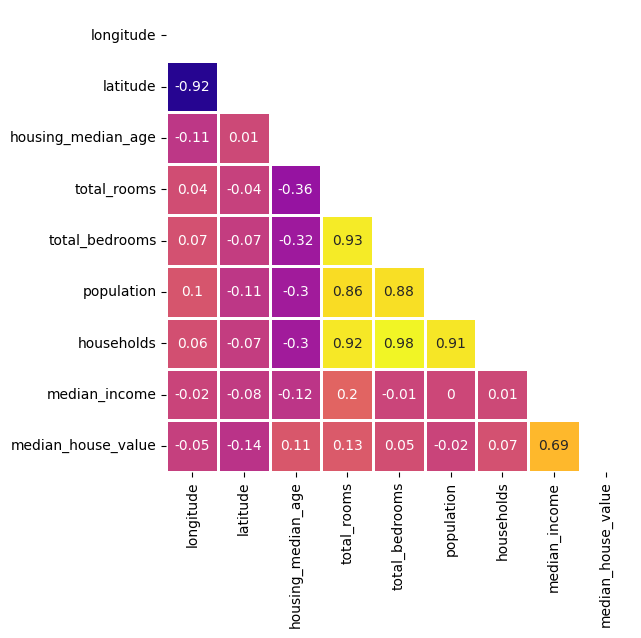

In [19]:
corrMat(df)

In [20]:
''' Draw a Bivariate Seaborn Pairgrid /w KDE density w/ '''
def snsPairGrid(df):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    g = sns.PairGrid(df,diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approximation on the diagonal
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1,alpha=0.4) # scattered plot on lower half
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=10) # kde approximation on lower half
    plt.tight_layout()

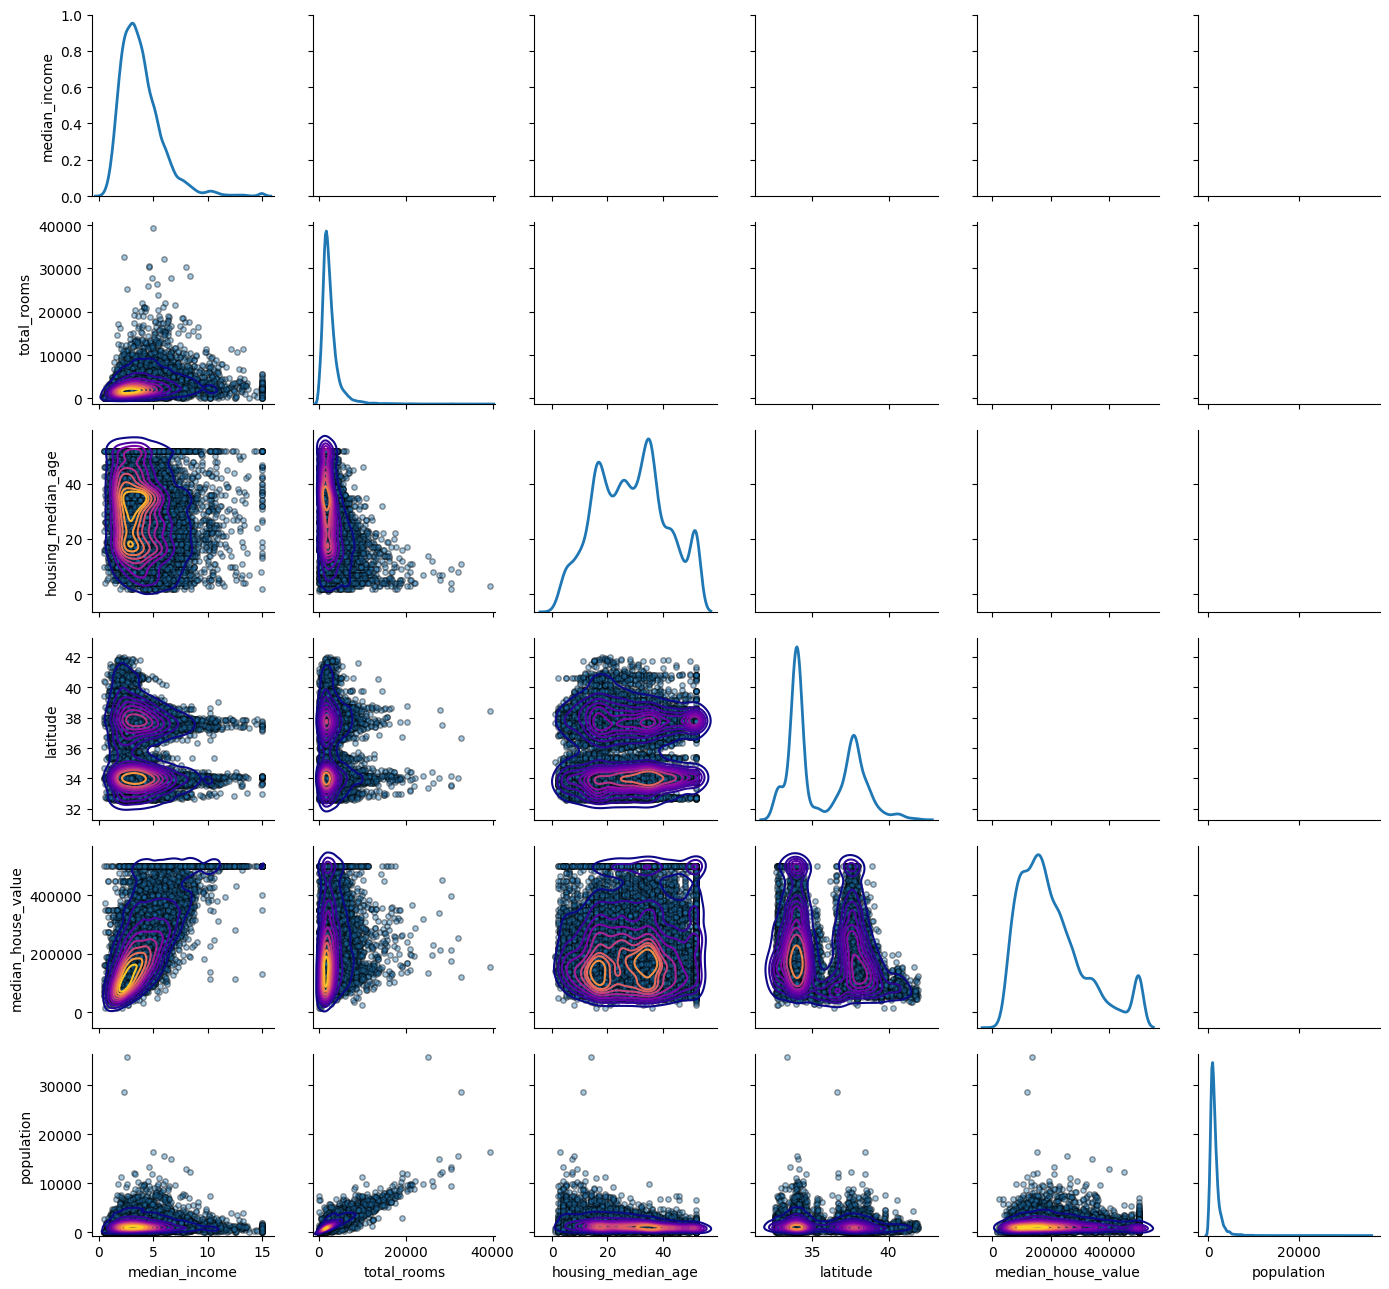

In [21]:
tlist = ['median_income','total_rooms','housing_median_age','latitude','median_house_value','population']
snsPairGrid(trdata[tlist])

In [22]:
import geoplot as gplt
from geoplot import crs as gcrs
''' Plot Two Geopandas Plots Side by Side '''
# defining a simple plot function, input list containing features of names found in dataframe
def plotTwo(df,lst):
    
    # load california from module, common for all plots
    cali = gpd.read_file(gplt.datasets.get_path('california_congressional_districts'))
    cali = cali.assign(area=cali.geometry.area)
    
    # Create a geopandas geometry feature; input dataframe should contain .longtitude, .latitude
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude,df.latitude))
    proj=gcrs.AlbersEqualArea(central_latitude=37.16611, central_longitude=-119.44944) # related to view

    ii=-1
    fig,ax = plt.subplots(1,2,figsize=(21,6),subplot_kw={'projection': proj})
    for i in lst:

        ii+=1
        tgdf = gdf.sort_values(by=i,ascending=True) 
        gplt.polyplot(cali,projection=proj,ax=ax[ii]) # the module already has california 
        gplt.pointplot(tgdf,ax=ax[ii],hue=i,cmap='plasma',legend=True,alpha=1.0,s=3) # 
        ax[ii].set_title(i)

    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.5)

In [23]:
trdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\2058100740.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cali = cali.assign(area=cali.geometry.area)
C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\2058100740.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cali = cali.assign(area=cali.geometry.area)


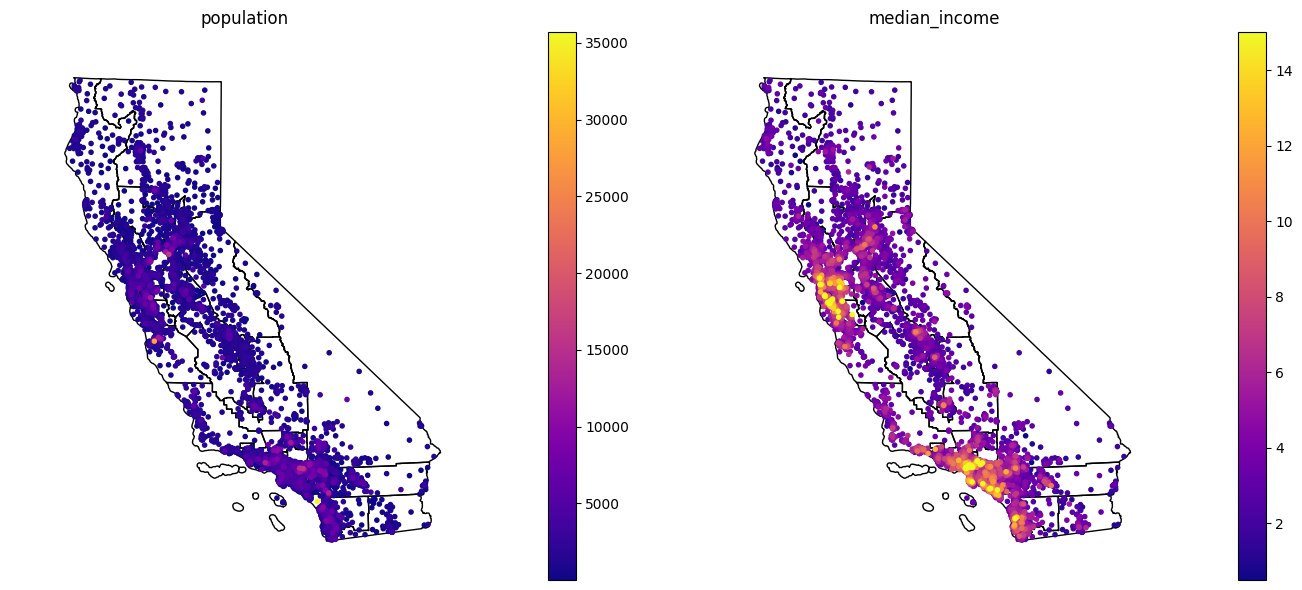

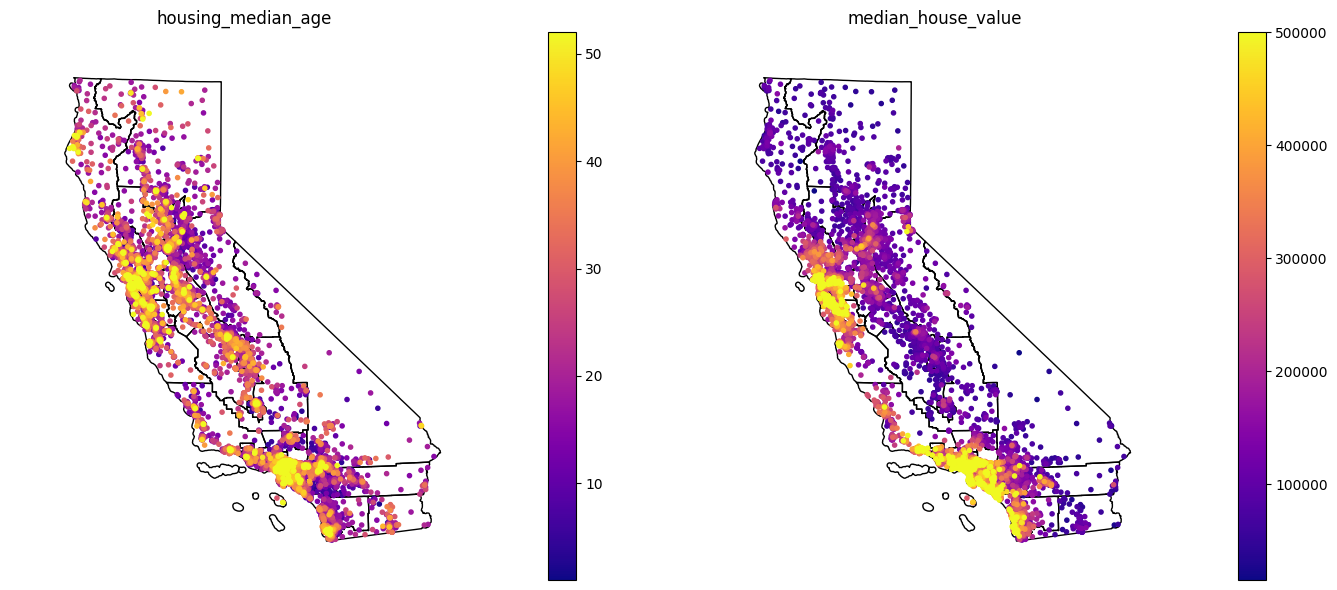

In [24]:
# Call function that plots two geopandas plots 
plotTwo(trdata,['population','median_income'])
plotTwo(trdata,['housing_median_age','median_house_value'])

### Removendo Outliers

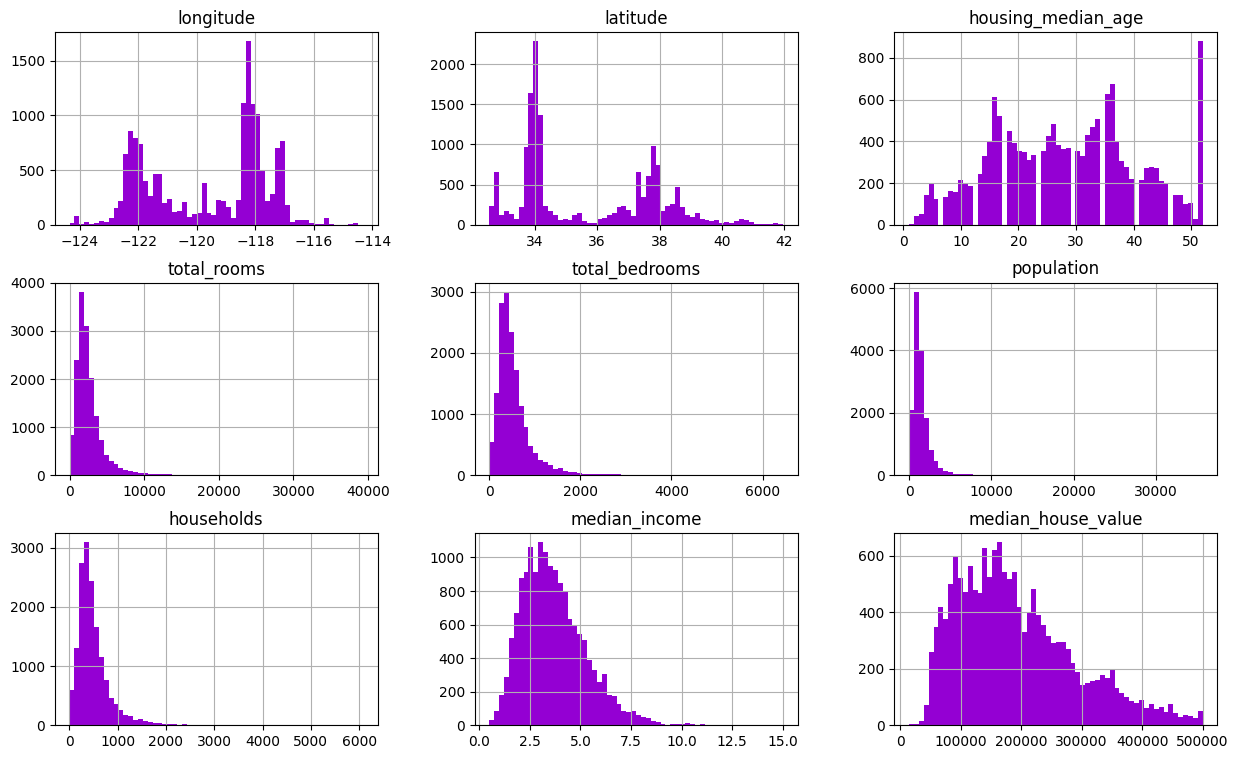

In [25]:
# trdata_upd : training data w/ removed outliers
maxval2 = trdata['median_house_value'].max() # get the maximum value
trdata_upd = trdata[trdata['median_house_value'] != maxval2] 
tedata_upd = tedata[tedata['median_house_value'] != maxval2]
trdata_upd.hist(bins=60, figsize=(15,9),color='darkviolet')
plt.show() # looks like its completely removed.

### Feature Engineering

C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\3972797958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trdata_upd['diag_coord'] = (trdata_upd['longitude'] + trdata_upd['latitude'])         # 'diagonal coordinate', works for this coord
C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\3972797958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trdata_upd['bedperroom'] = trdata_upd['total_bedrooms']/trdata_upd['total_rooms']     # feature w/ bedrooms/room ratio


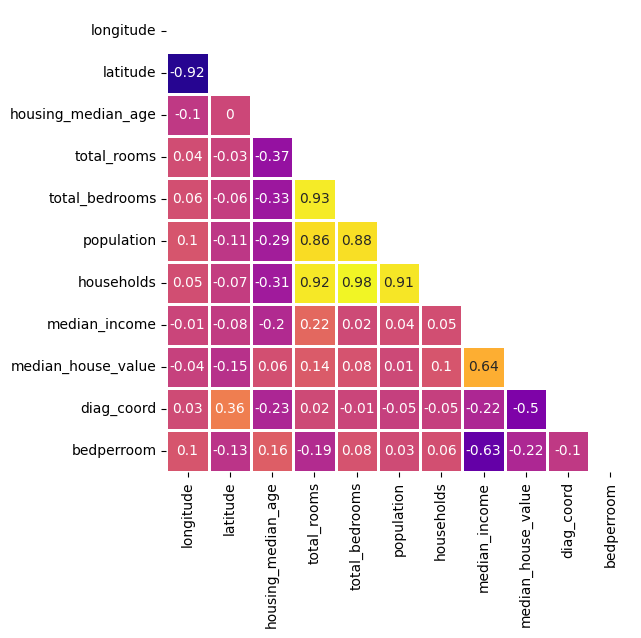

C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\3972797958.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tedata_upd['diag_coord'] = (tedata_upd['longitude'] + tedata_upd['latitude'])
C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\3972797958.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tedata_upd['bedperroom'] = tedata_upd['total_bedrooms']/tedata_upd['total_rooms']     # feature w/ bedrooms/room ratio


In [26]:
# Make a feature that contains both longtitude & latitude
trdata_upd['diag_coord'] = (trdata_upd['longitude'] + trdata_upd['latitude'])         # 'diagonal coordinate', works for this coord
trdata_upd['bedperroom'] = trdata_upd['total_bedrooms']/trdata_upd['total_rooms']     # feature w/ bedrooms/room ratio
corrMat(trdata_upd)
# update test data as well
tedata_upd['diag_coord'] = (tedata_upd['longitude'] + tedata_upd['latitude'])
tedata_upd['bedperroom'] = tedata_upd['total_bedrooms']/tedata_upd['total_rooms']     # feature w/ bedrooms/room ratio

C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\2058100740.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cali = cali.assign(area=cali.geometry.area)
C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\2058100740.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cali = cali.assign(area=cali.geometry.area)


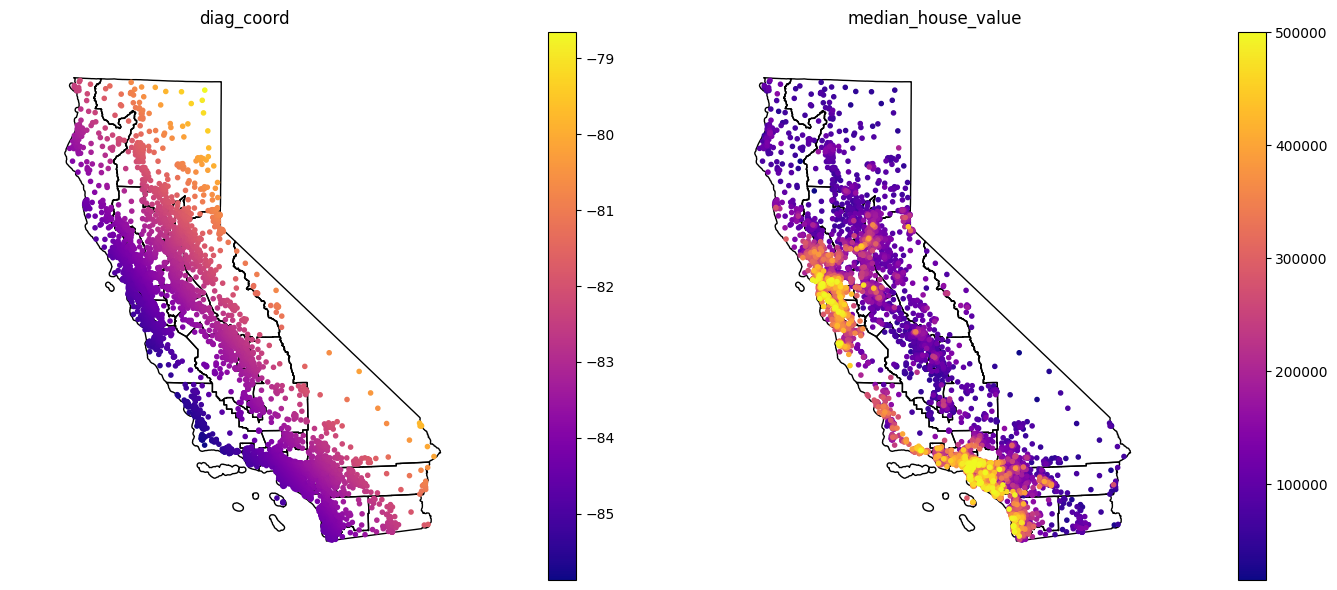

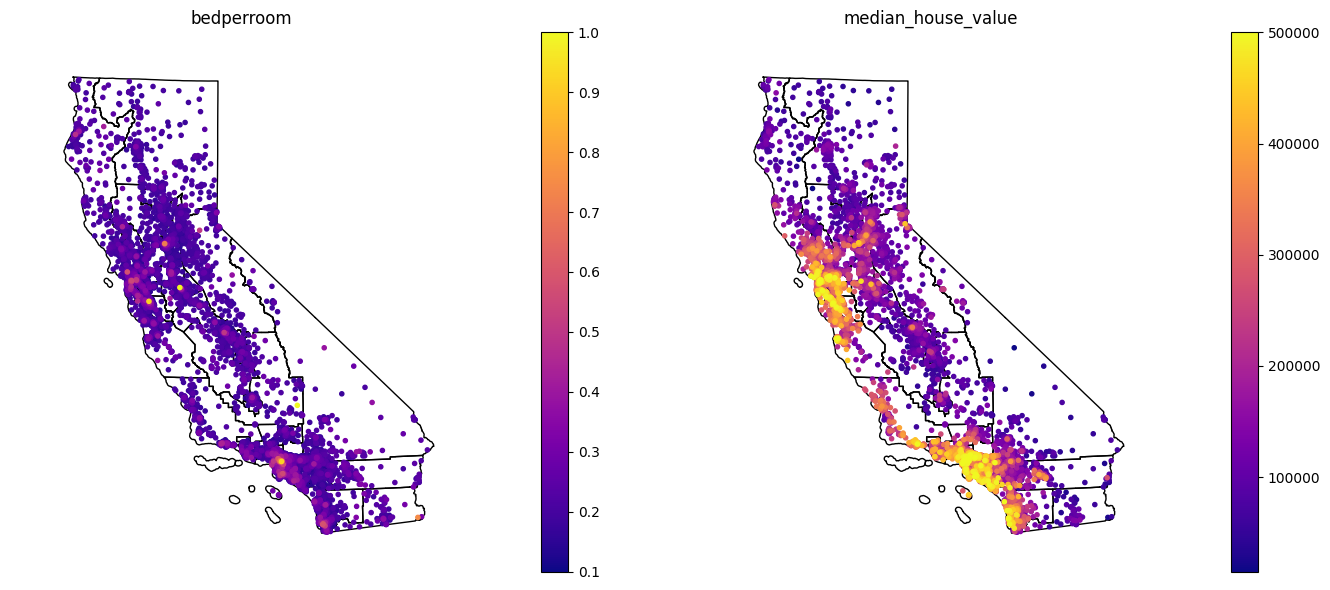

In [27]:
# lets plot them as well
plotTwo(trdata_upd,['diag_coord','median_house_value'])
plotTwo(trdata_upd,['bedperroom','median_house_value'])

### ML Models to Predict the Median House Value

In [28]:
''' Draw a a single Heatmap using Seaborn '''
def heatmap1(values,xlabel,ylabel,xticklabels,yticklabels,
            cmap='plasma',vmin=None,vmax=None,fmt="%0.2f"):

    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(values, ax=ax,cmap=cmap)
    
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel);ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + 0.5)
    ax.set_yticks(np.arange(len(yticklabels)) + 0.5)
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    ax.set_title('BR()')
    ax.set_aspect(1)
    
    for p, color, value in zip(img.get_paths(), img.get_facecolors(),img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")

In [29]:
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
# Model Evaluation w/ Cross Validation
def modelEval(ldf,feature='median_house_value',model_id = 'dummy'):
    
    # Input: Feature & Target DataFrame

    # Split feature/target variable
    y = ldf[feature].copy()
    X = ldf.copy()
    del X[feature]     # remove target variable
    
    # Pick Model 
    if(model_id is 'dummy'):    model = DummyRegressor()
    # if(model_id is 'br'):    model = BR(verbose=False)  
    if(model_id is 'rf'):    model = RandomForestRegressor(n_estimators=10,random_state=10)
    
    ''' Parameter Based Cross Validation (No Pipeline)'''
#     gscv = GridSearchCV(model,param_grid,cv=5)
#     gscv.fit(X,y)
#     results = pd.DataFrame(gscv.cv_results_)
#     scores = np.array(results.mean_test_score).reshape(7,7)
    
#     # plot the cross validation mean scores
#     heatmap1(scores,xlabel='lamda',xticklabels=param_grid['lamd'],
#                     ylabel='alpha',yticklabels=param_grid['alph'])
    
    ''' Standard Cross Validation '''
    cv_score = np.sqrt(-cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error'))
    print("Scores:",cv_score);print("Mean:", cv_score.mean());print("std:", cv_score.std())

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\1921789557.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(model_id is 'dummy'):    model = DummyRegressor()
C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\1921789557.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(model_id is 'rf'):    model = RandomForestRegressor(n_estimators=10,random_state=10)


In [36]:
# A simple comparison model
modelEval(trdata,model_id='dummy')

Scores: [117026.36942376 113925.36940626 116043.75597649 114285.40011268
 116811.88811314]
Mean: 115618.55660646668
std: 1283.0401902905567


In [38]:
# lets remove two of the three similar features
del trdata_upd['total_bedrooms']
del trdata_upd['total_rooms']

### ML Pipeline

In [39]:
''' Plot Two Seaborn Heatmaps Side by Side '''
# used for Polynomial vs non polynomial cross validaion score comparison
def heatmap2(values,values2,xlabel,ylabel,xticklabels,yticklabels,
			cmap='plasma',vmin=None,vmax=None,fmt="%0.2f"):

	fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
	sns.heatmap(values, ax=ax1,cmap=cmap)
	sns.heatmap(values2, ax=ax2,cmap=cmap)
	
	img = ax1.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
	img.update_scalarmappable()
	ax1.set_xlabel(xlabel);ax1.set_ylabel(ylabel)
	ax1.set_xticks(np.arange(len(xticklabels)) + 0.5)
	ax1.set_yticks(np.arange(len(yticklabels)) + 0.5)
	ax1.set_xticklabels(xticklabels);ax1.set_yticklabels(yticklabels)
	ax1.set_title('PolynomialFeatures(2) + BR()')
	ax1.set_aspect(1)
	
	for p, color, value in zip(img.get_paths(), img.get_facecolors(),img.get_array()):
		x, y = p.vertices[:-2, :].mean(0)
		if np.mean(color[:3]) > 0.5:
			c = 'k'
		else:
			c = 'w'
		ax1.text(x, y, fmt % value, color=c, ha="center", va="center")
		
	img = ax2.pcolor(values2, cmap=cmap, vmin=vmin, vmax=vmax)
	img.update_scalarmappable()
	ax2.set_xlabel(xlabel);ax2.set_ylabel(ylabel)
	ax2.set_xticks(np.arange(len(xticklabels)) + 0.5)
	ax2.set_yticks(np.arange(len(yticklabels)) + 0.5)
	ax2.set_xticklabels(xticklabels);ax2.set_yticklabels(yticklabels)
	ax2.set_title('PolynomialFeatures(3) + BR()')
	ax2.set_aspect(1)
	
	for p, color, value in zip(img.get_paths(), img.get_facecolors(),img.get_array()):
		x, y = p.vertices[:-2, :].mean(0)
		if np.mean(color[:3]) > 0.5:
			c = 'k'
		else:
			c = 'w'
		ax2.text(x, y, fmt % value, color=c, ha="center", va="center")

In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [42]:
def modelEval2(ldf,feature='median_house_value',model_id = 'dummy',scaling_id=False):

    # Given a dataframe, split feature/target variable
    y = ldf[feature].copy()
    X = ldf.copy()
    del X[feature]     # remove target variable
    
    tlst = []
    for i in [2,3]:
        
        # Pick Model 
        if(model_id is 'dummy'):    model = DummyRegressor()
        if(model_id is 'rf'):    model = RandomForestRegressor(n_estimators=10,random_state=10)

        # Pick a Pipeline (Polynomial Feature Adjustment + Model)
        if(scaling_id is False):
            pipe = Pipeline(steps=[('poly',PolynomialFeatures(i)),
                                   ('model',model)])
        else:
            pipe = Pipeline(steps=[('scaler',StandardScaler()),
                                   ('poly',PolynomialFeatures(i)),
                                   ('model',model)])

        ''' Parameter Based Cross Validation (With Pipeline)'''
        # define a parameter search grid, pipepines require slightly different notations w/ __
#         param_grid = {
#         'model__lamd': [0.0001,0.001, 0.01, 0.1, 1, 10, 100],
#         'model__alph': [0.0001,0.001, 0.01, 0.1, 1, 10, 100]}
        
#         gscv2 = GridSearchCV(pipe, param_grid,cv=5)
#         gscv2.fit(X,y)
#         ypred = gscv2.predict(X)
#         results2 = pd.DataFrame(gscv2.cv_results_)
#         scores2 = np.array(results2.mean_test_score).reshape(7,7)
#         tlst.append(scores2)
        
        ''' Standard Cross Validation '''
        cv_score = np.sqrt(-cross_val_score(pipe,X,y,cv=5,scoring='neg_mean_squared_error'))
        print("Scores:",cv_score.round(2))
        print("Mean:", cv_score.mean().round(2));print("std:", cv_score.std().round(2))
    
#     plot mean of 5 cross validation segment score
#     heatmap2(tlst[0],tlst[1],xlabel='lamd', xticklabels=param_grid['model__lamd'],
#                              ylabel='alph', yticklabels=param_grid['model__alph'])

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\2282479694.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(model_id is 'dummy'):    model = DummyRegressor()
C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\2282479694.py:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(model_id is 'rf'):    model = RandomForestRegressor(n_estimators=10,random_state=10)


In [ ]:
modelEval2(trdata_upd,model_id='br',scaling_id=False)

In [ ]:
modelEval2(trdata_upd,model_id='br',scaling_id=True)

In [45]:
trdata_upd.drop('ocean_proximity',axis=1,inplace=True)

C:\Users\bre_p\AppData\Local\Temp\ipykernel_18768\1909856822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trdata_upd.drop('ocean_proximity',axis=1,inplace=True)


In [46]:
modelEval(trdata_upd,model_id='rf')

Scores: [47376.56322789 45895.97066786 45929.10618583 47237.76781618
 49122.5238755 ]
Mean: 47112.38635465242
std: 1183.721408520872
